In [1]:
import sys, os, pickle
import numpy as np
from dsc.dsc_io import load_dsc as __load_dsc__, source_dirs as __source_dirs__

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
data = __load_dsc__(['/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering/changepoint/changepoint_28.pkl',
                     '/home/saikatbanerjee/scratch/work/gradvi-experiments/trendfiltering/genlasso/changepoint_28_genlasso_1.rds'])

INFO: Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.
INFO: cffi mode is CFFI_MODE.ANY
INFO: R home found: /software/R-3.6.1-el7-x86_64/lib64/R
INFO: R library path: /software/R-3.6.1-el7-x86_64/lib64/R/lib:/usr/local/lib64:/software/java-1.8-x86_64/jre/lib/amd64/server:/software/intel/parallel_studio_xe_2020_update1/mkl/lib/intel64:/software/R-3.6.1-el7-x86_64/lib64/R/lib:/software/R-3.6.1-el7-x86_64/lib64:/software/curl-7.50-el7-x86_64/lib:/software/java-1.8-x86_64/lib:/software/openblas-0.2.19-el7-x86_64/lib:/software/gcc-10.2.0-el7-x86_64/lib64:/software/gcc-10.2.0-el7-x86_64/lib:/software/slurm-current-el7-x86_64/lib64:/software/slurm-current-el7-x86_64/lib:/software/git-2.10-el7-x86_64/lib64:/software/subversion-1.9.4-el7-x86_64/lib:/software/serf-1.3.9-el7-x86_64/lib
INFO: LD_LIBRARY_PATH: /software/intel/parallel_studio_xe_2020_update1/mkl/lib/intel64:/software/R-3.6.1-el7-x86_64/lib64/R/lib

In [3]:
data.keys()

dict_keys(['X', 'Xinv', 'y', 'ytest', 'ytrue', 'beta', 'snr', 'degree', 'DSC_DEBUG', 'tf_y', 'tf_model'])

In [4]:
X = data['X']
Xinv = data['Xinv']
degree = data['degree']
y = data['y']
yinit = data['tf_y']
ytrue = data['ytrue']

In [5]:
from gradvi.tests import toy_priors
from gradvi.inference import LinearRegression
from gradvi.optimize import moving_average as gv_moving_average

prior_init = toy_priors.get_ash_scaled(k = 20, sparsity = 0.9, skbase = (degree + 1) * 20)
print(prior_init.sk)

binit  = np.dot(Xinv, yinit)
s2init = np.var(y - yinit) / 10.0
print(s2init)

[ 0.          0.16158635  0.34928285  0.56730854  0.8205642   1.11474253
  1.45645605  1.85338582  2.31445402  2.85002454  3.47213595  4.19477208
  5.03417634  6.00921686  7.14181063  8.45741609  9.98560543 11.76072931
 13.82268898 16.21783319]
0.0011087568353385494


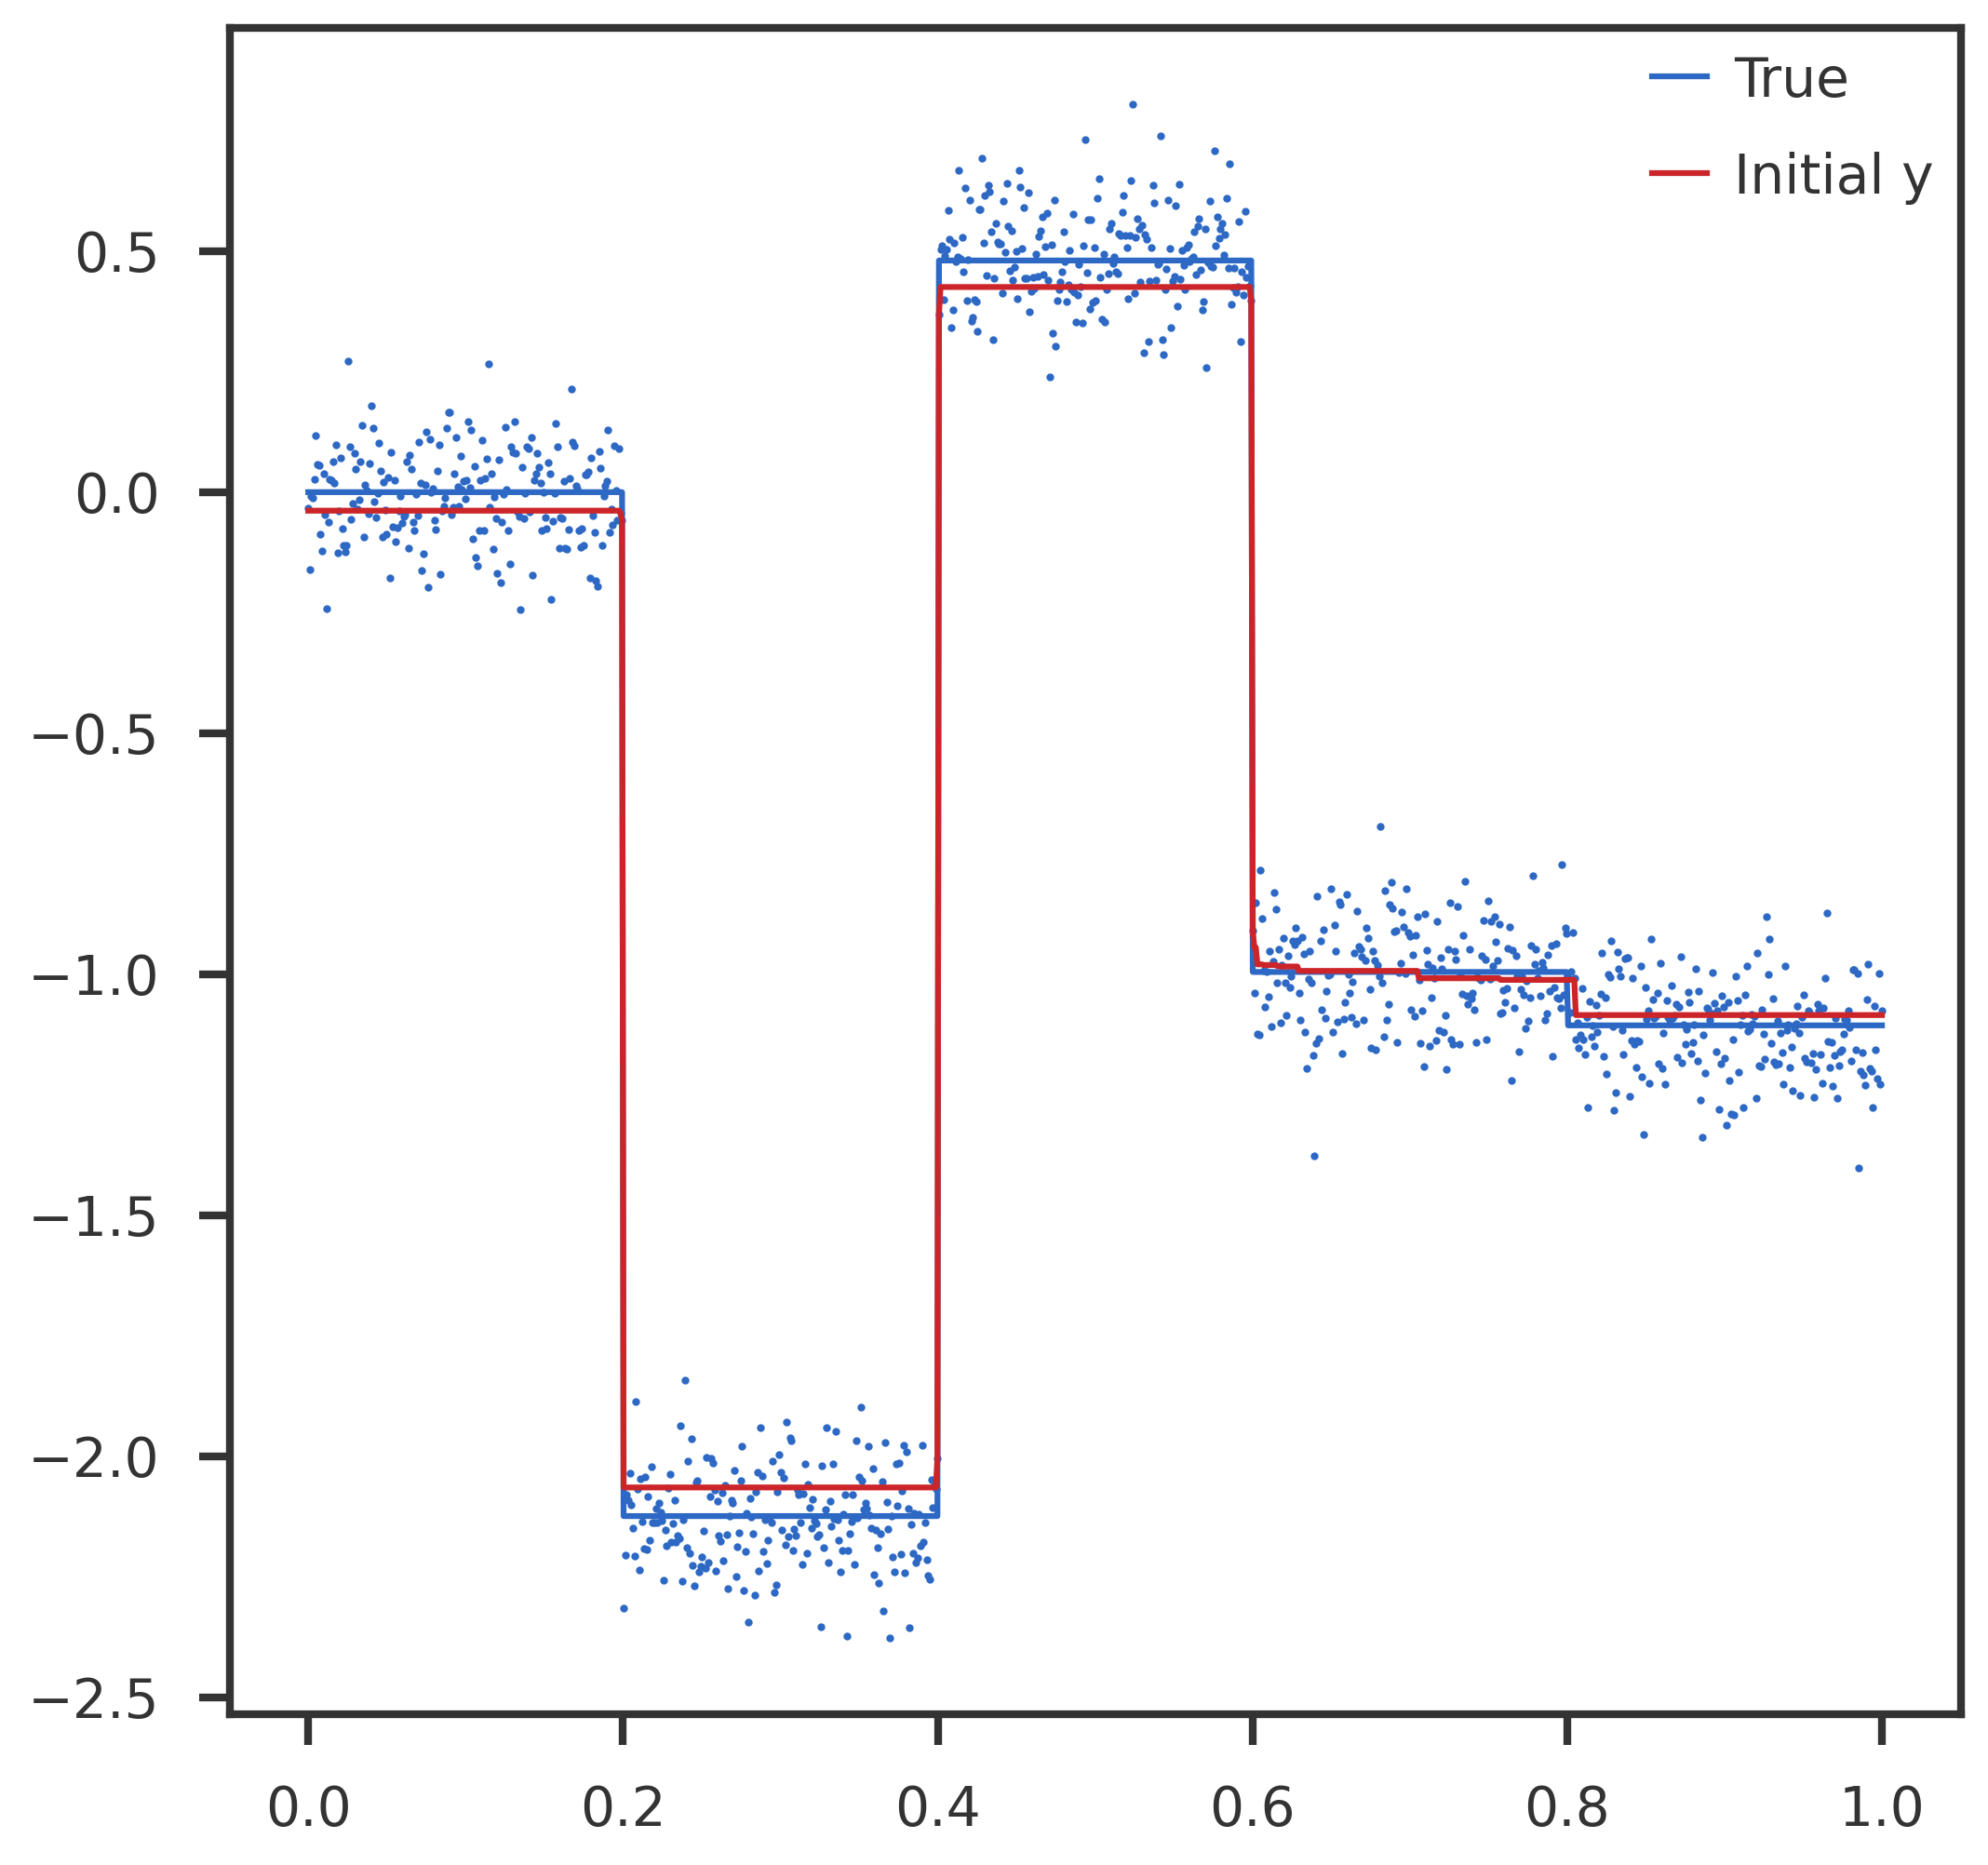

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

xvals = np.linspace(0, 1, y.shape[0])
ax1.scatter(xvals, y, s = 1)
ax1.plot(xvals, ytrue, label = "True")
ax1.plot(xvals, np.dot(X, binit), label = "Initial y")
ax1.legend()
plt.show()

In [8]:
prior_init.w

array([0.9       , 0.00526316, 0.00526316, 0.00526316, 0.00526316,
       0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.00526316,
       0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.00526316,
       0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.00526316])

In [9]:
gv0 = LinearRegression(optimize_s = False, optimize_b = False, fit_intercept = True,
                       maxiter = 1000, obj = 'direct', tol = 1e-7)
gv0.fit(X, y, prior_init, b_init = binit, s2_init = s2init)

print(f"Iterations: {gv0.niter}")
print(gv0.fitobj.message)
print(f"Intercept: {gv0.intercept}")

Iterations: 18
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Intercept: -0.7529605374927534


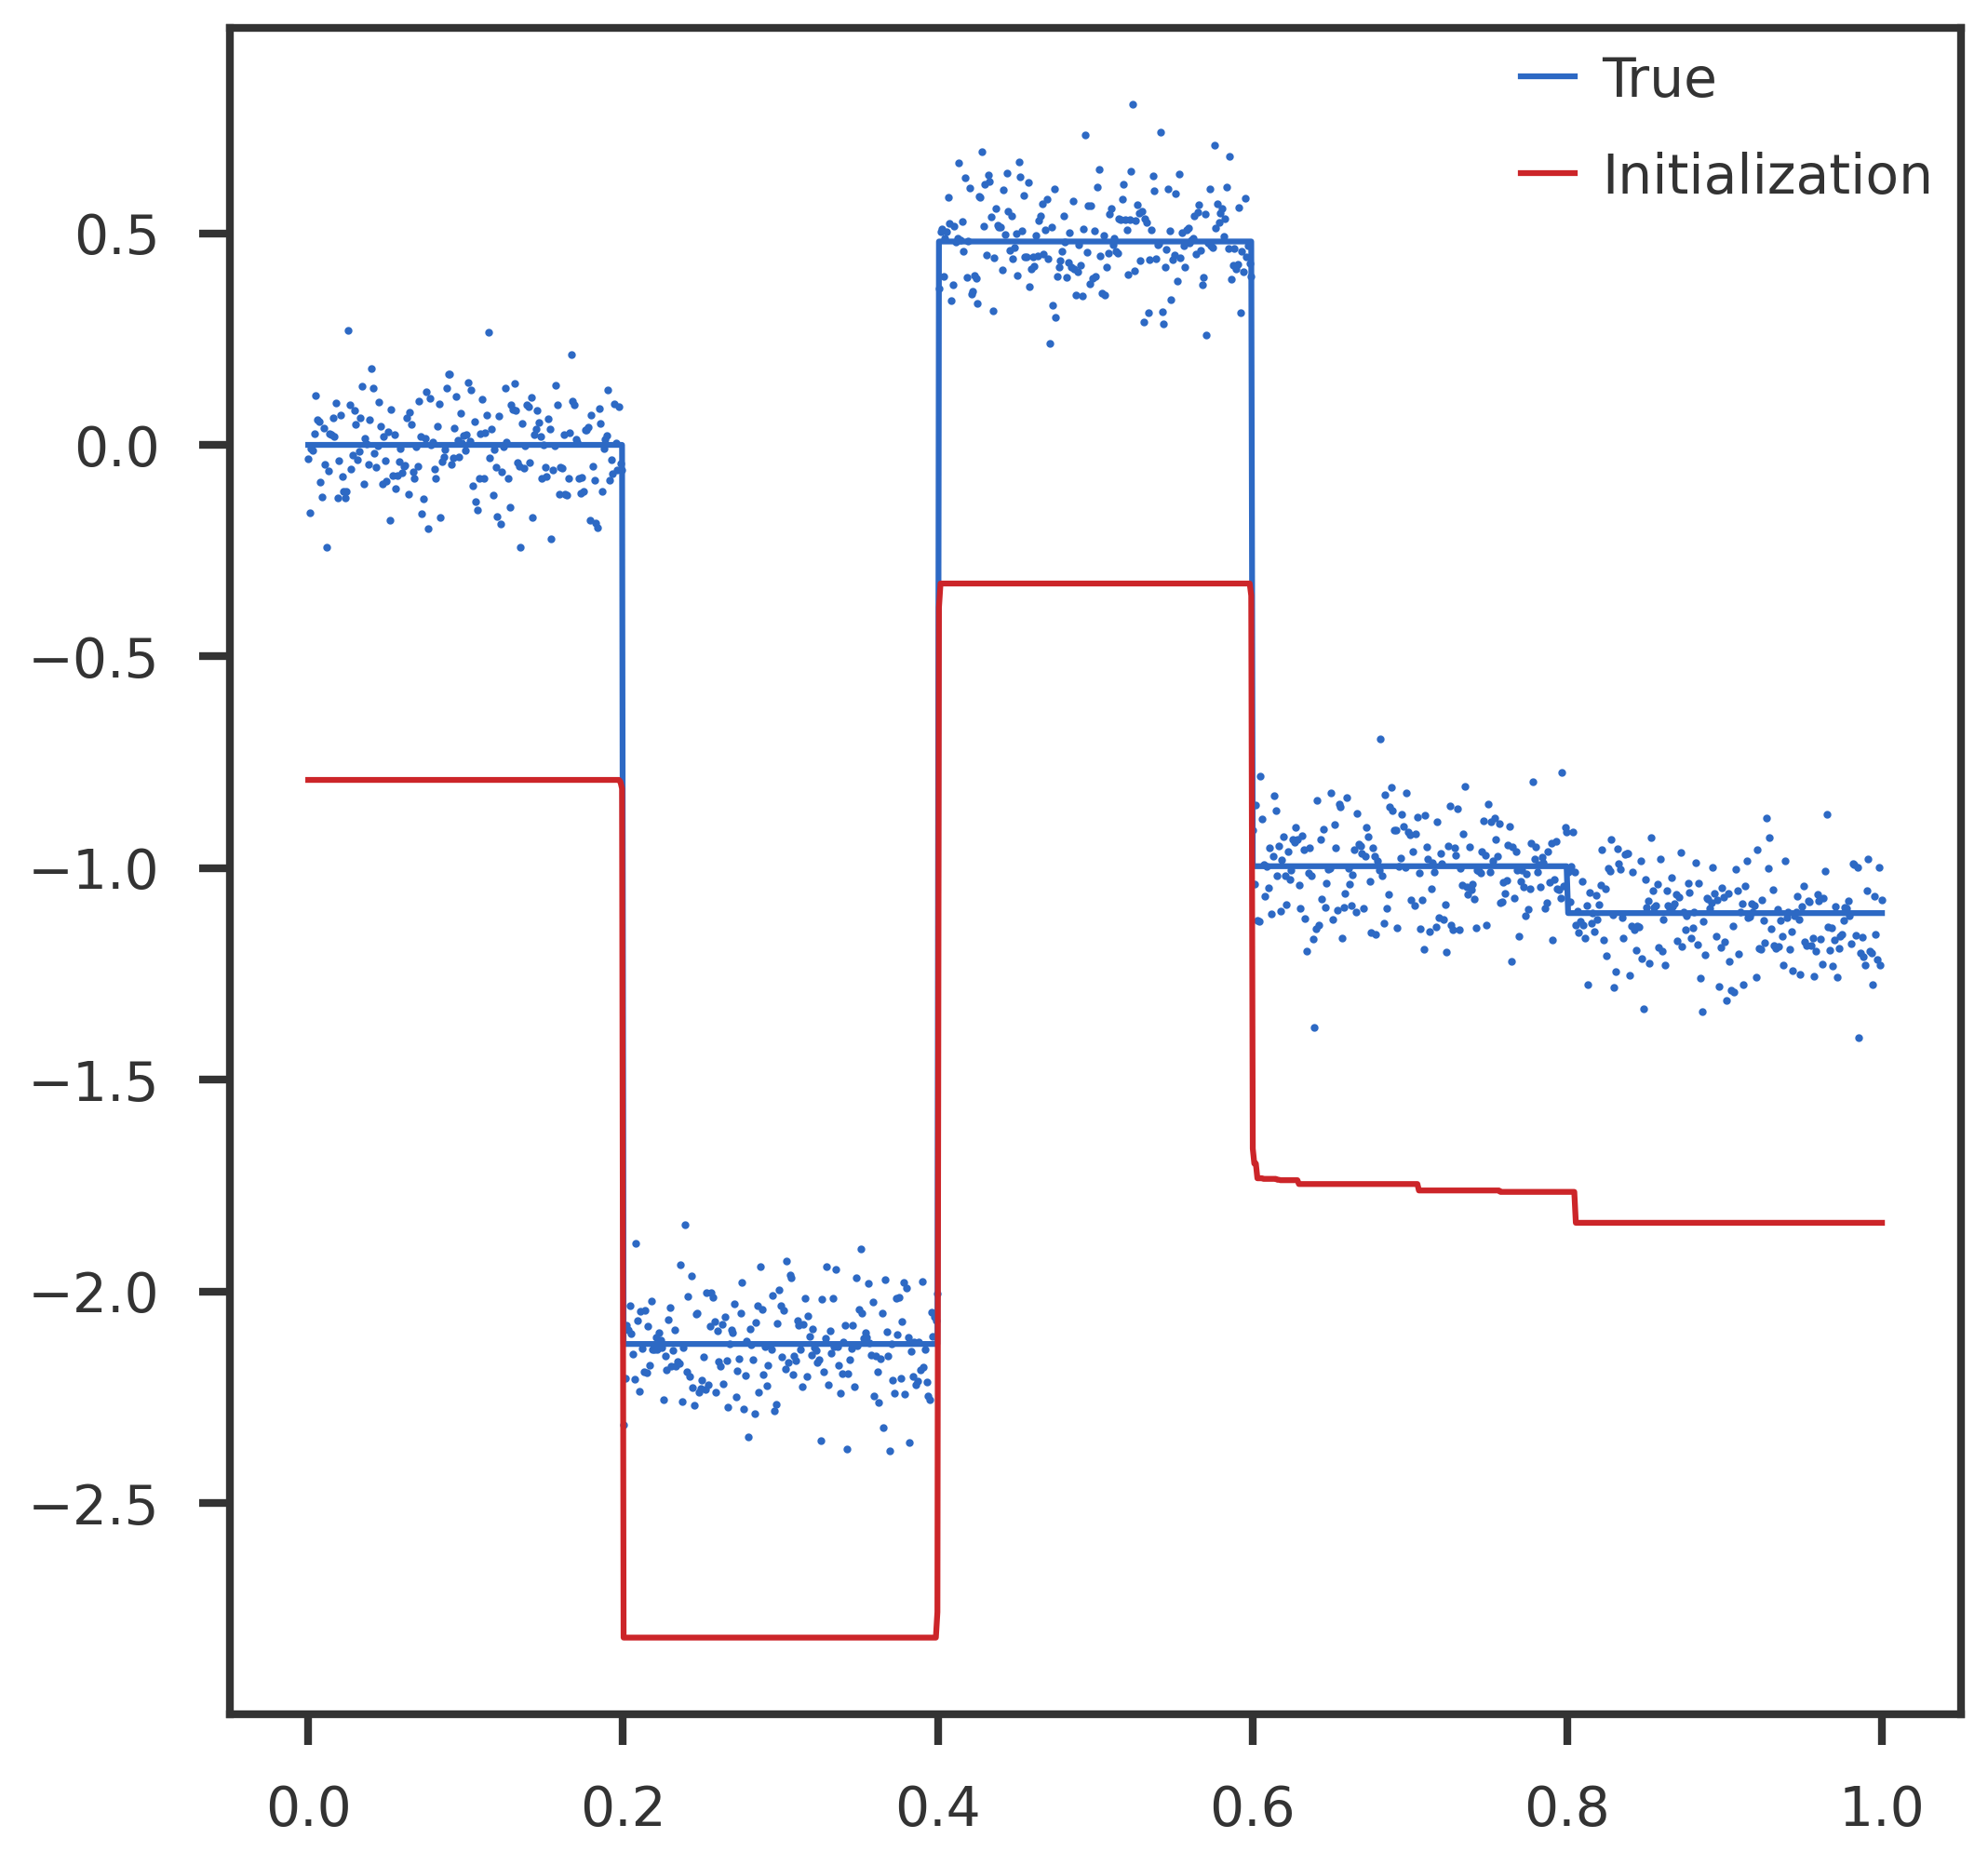

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
xvals = np.linspace(0, 1, y.shape[0])
ax1.scatter(xvals, y, s = 1)
ax1.plot(xvals, ytrue, label = "True")
ax1.plot(xvals, np.dot(X, gv0.coef) + gv0.intercept, label = "Initialization")
ax1.legend()
plt.show()

In [11]:
gv = LinearRegression(obj = 'direct')
gv.fit(X, y, gv0.prior, b_init = gv0.coef, s2_init = gv0.residual_var)


print(f"Iterations: {gv.niter}")
print(gv.fitobj.message)
print(f"Intercept: {gv.intercept}")

Iterations: 2000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Intercept: -0.7529605374927534


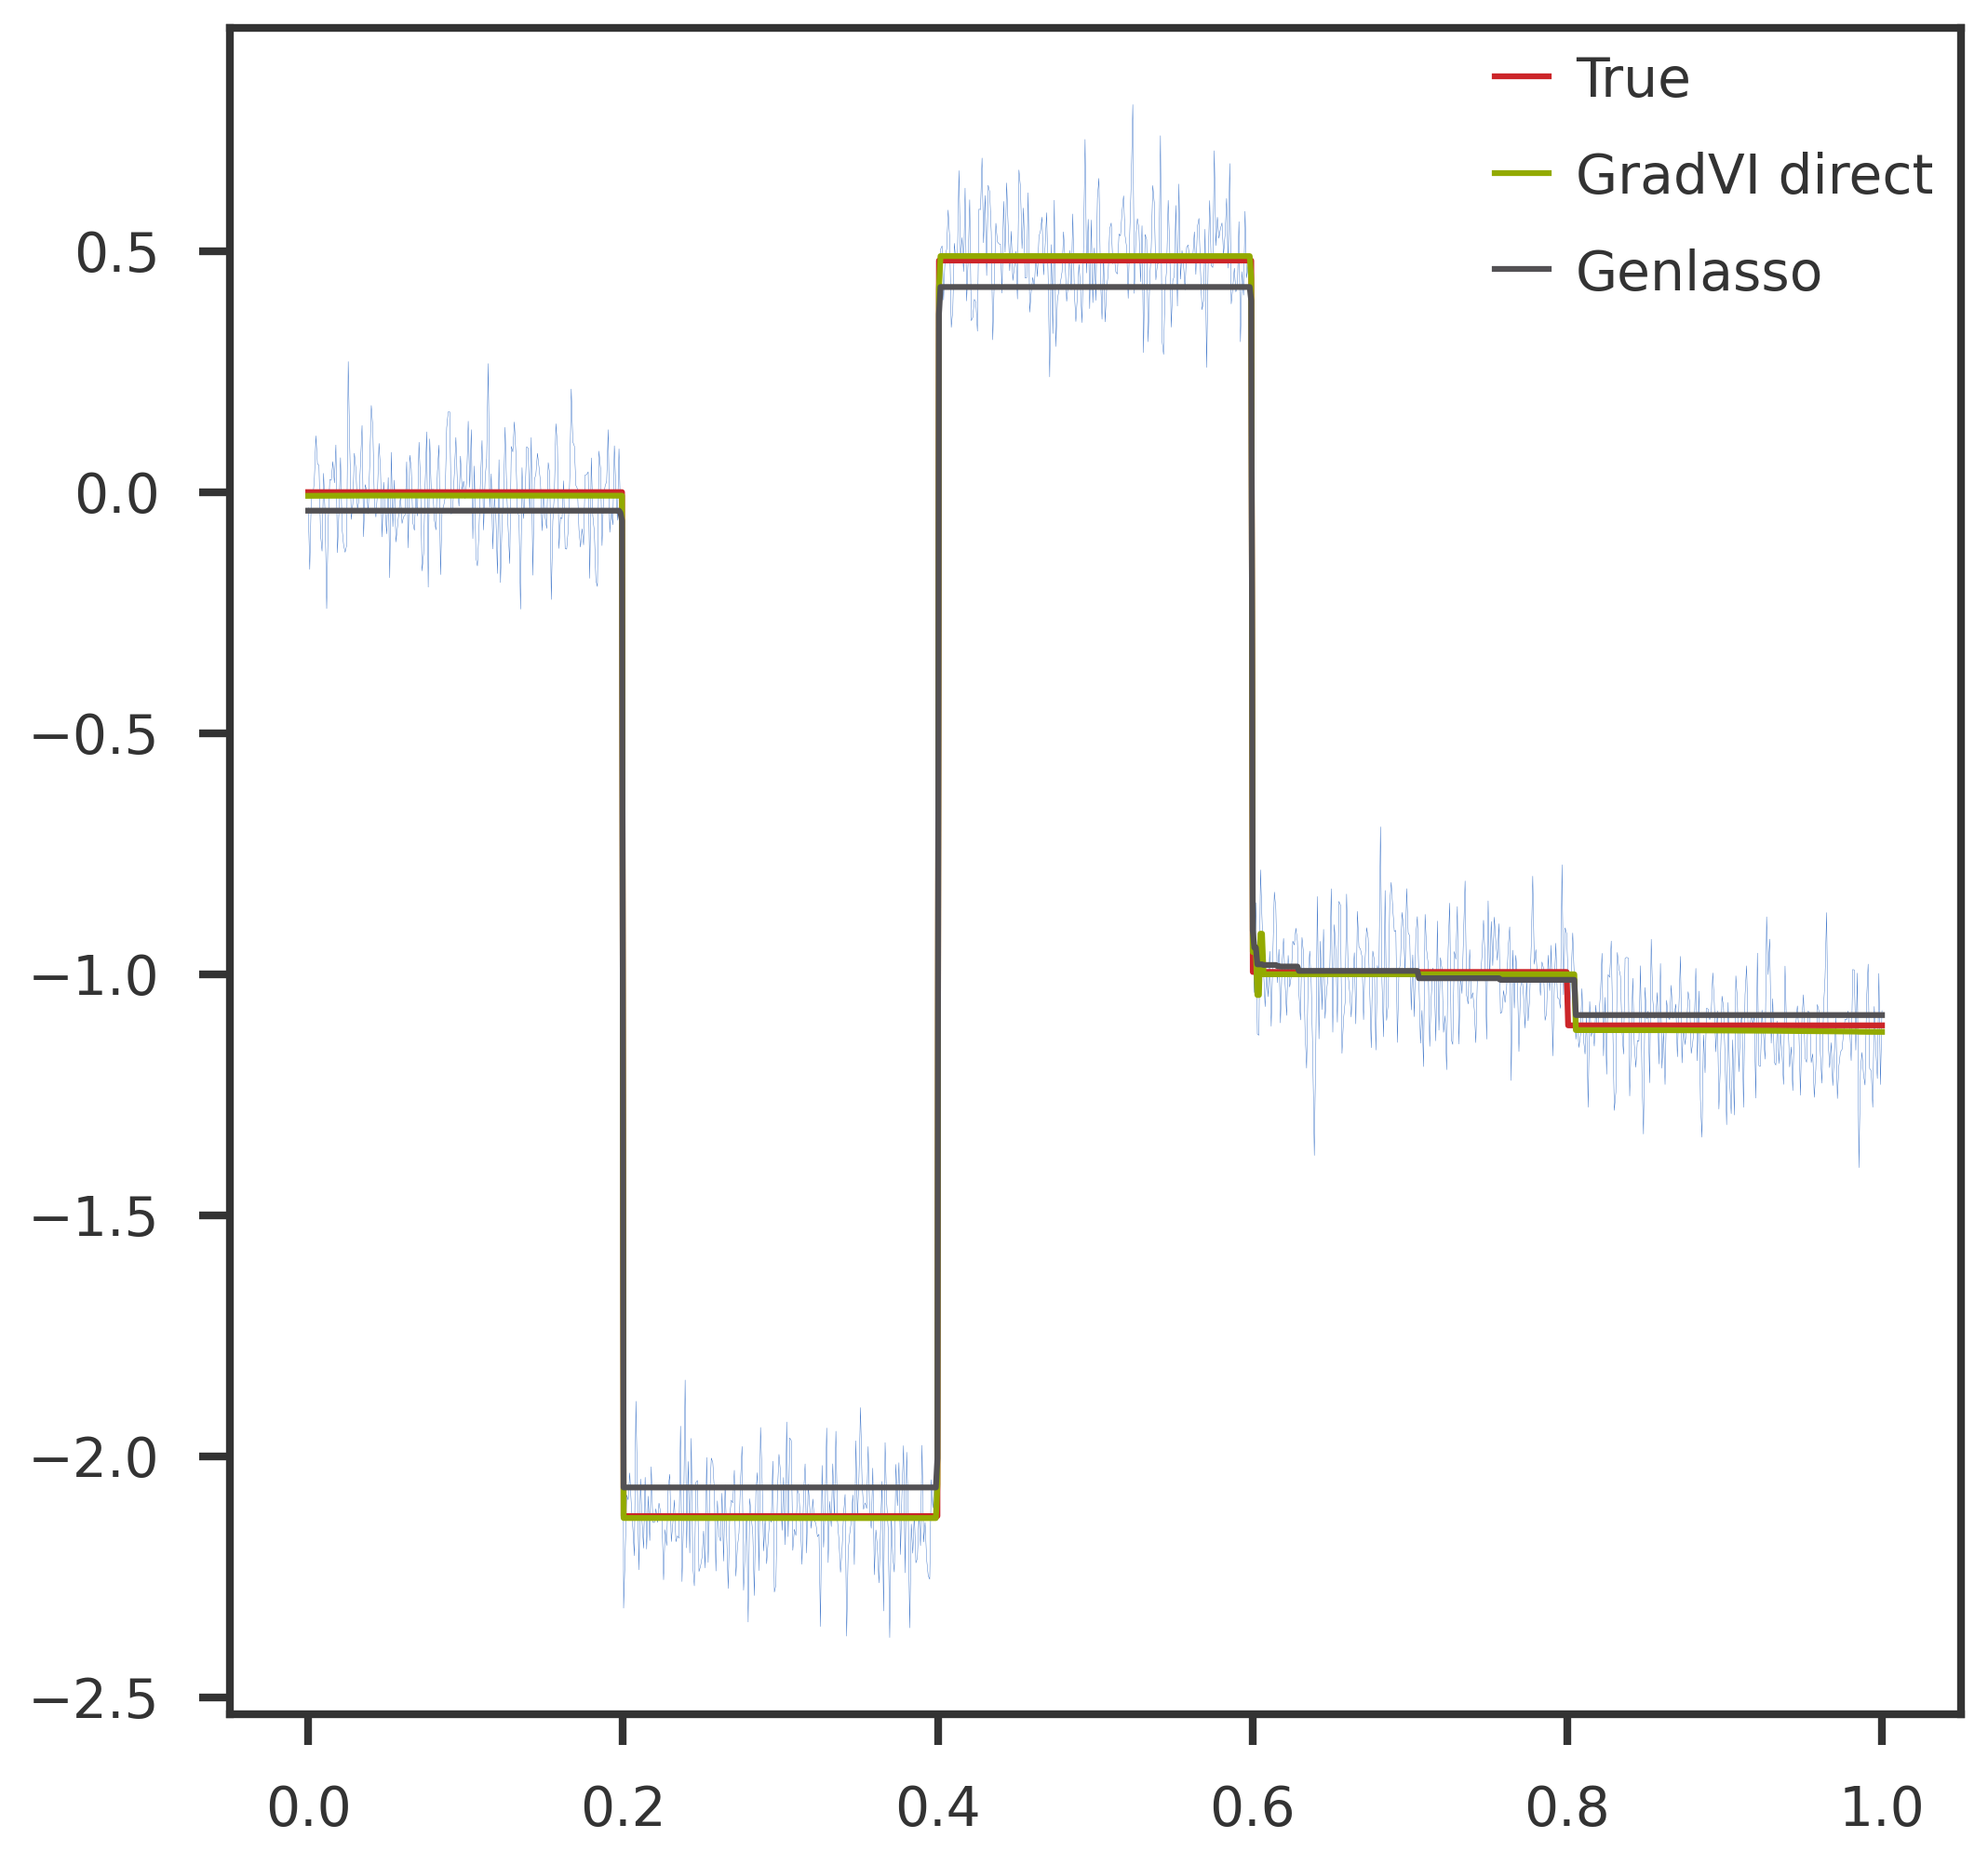

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
xvals = np.linspace(0, 1, y.shape[0])
#ax1.scatter(xvals, y, s = 1)
ax1.plot(xvals, y, lw = 0.1)
ax1.plot(xvals, ytrue, label = "True")
ax1.plot(xvals, np.dot(X, gv.coef) + gv.intercept, label = "GradVI direct")
ax1.plot(xvals, yinit, label = "Genlasso")
ax1.legend()
plt.show()

In [ ]:
path = "../dsc/functions/"

In [14]:
for name, func in __source_dirs__(['../dsc/functions']):
    globals()[name] = func
from fit_gradvi import fit_ash_trendfiltering_gradvi

In [16]:
s2init = None
ncomp = 20
sparsity = 0.9 
skbase = 20
objtype = "direct"

binit = np.dot(Xinv, yinit)
run_init = True
model, mu, beta = fit_ash_trendfiltering_gradvi(X, y, objtype,
                    degree = degree, ncomp = ncomp, sparsity = sparsity, skbase = skbase,
                    binit = binit, s2init = s2init, run_initialize = run_init)

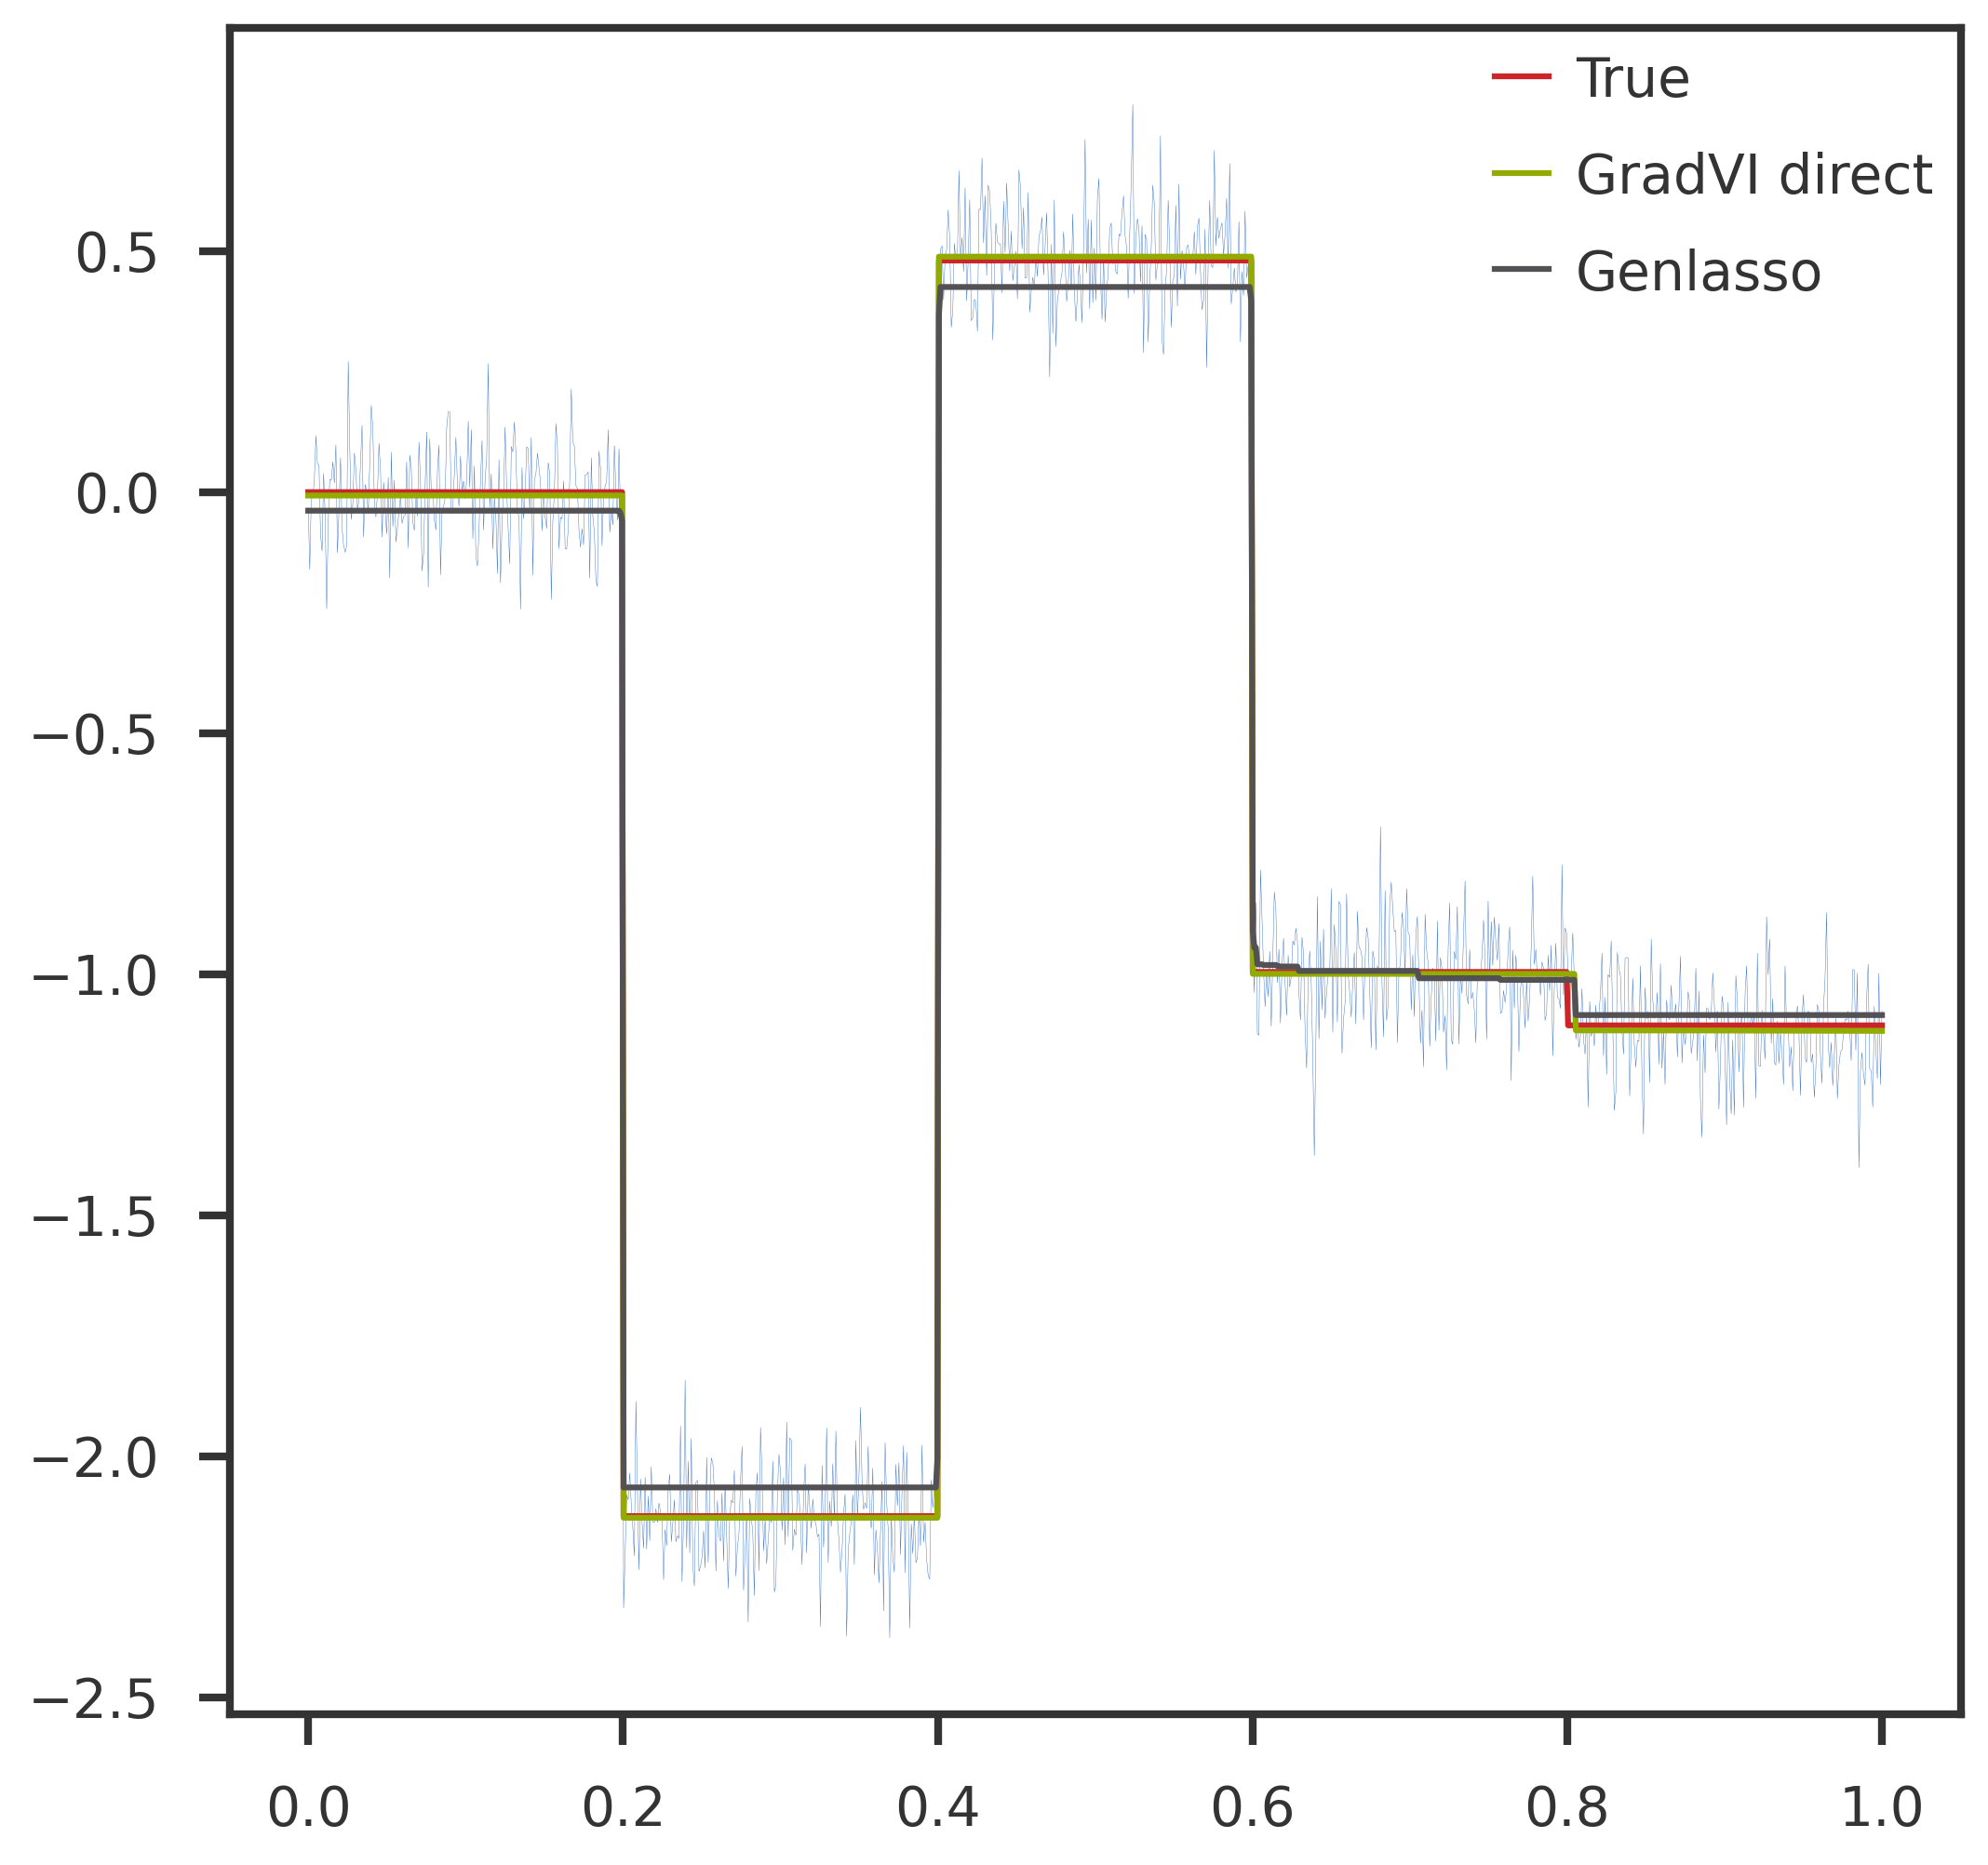

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
xvals = np.linspace(0, 1, y.shape[0])
#ax1.scatter(xvals, y, s = 1)
ax1.plot(xvals, y, lw = 0.1)
ax1.plot(xvals, ytrue, label = "True")
ax1.plot(xvals, np.dot(X, beta) + mu, label = "GradVI direct")
ax1.plot(xvals, yinit, label = "Genlasso")
ax1.legend()
plt.show()

In [19]:
model['prior']

{'smbase': 2.718281828459045,
 'sk': array([ 0.        ,  0.16158635,  0.34928285,  0.56730854,  0.8205642 ,
         1.11474253,  1.45645605,  1.85338582,  2.31445402,  2.85002454,
         3.47213595,  4.19477208,  5.03417634,  6.00921686,  7.14181063,
         8.45741609,  9.98560543, 11.76072931, 13.82268898, 16.21783319]),
 'w': array([9.93958596e-01, 3.25974272e-04, 3.24868397e-04, 3.21638304e-04,
        3.18483188e-04, 3.16134265e-04, 3.14434537e-04, 3.13192646e-04,
        3.12358480e-04, 3.12147208e-04, 3.12793432e-04, 3.14203164e-04,
        3.16062070e-04, 3.17991578e-04, 3.19605550e-04, 3.20627530e-04,
        3.20974887e-04, 3.20730529e-04, 3.20057556e-04, 3.19126045e-04]),
 'wmod': array([ 2.65525975, -5.36737262, -5.37077091, -5.38076344, -5.39062139,
        -5.39802406, -5.40341517, -5.40737259, -5.41003958, -5.41071618,
        -5.40864807, -5.40415128, -5.39825246, -5.39216618, -5.3871035 ,
        -5.38391097, -5.38282819, -5.38358978, -5.38569023, -5.38860493]),
 